In [1]:
from IPython.display import display, Image

# Lab 4 - Convolutional Neural Network with MNIST

This lab corresponds to Module 4 of the "Deep Learning Explained" course. We assume that you have successfully Lab 1 to download the MNIST data.

We will train a Convolutional Neural Network (CNN) on MNIST data. 

## Introduction

A [convolutional neural network](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNN, or ConvNet) is a type of [feed-forward](https://en.wikipedia.org/wiki/Feedforward_neural_network) artificial neural network made up of neurons that have learnable weights and biases, very similar to ordinary multi-layer perceptron (MLP) networks introduced in Module 3. The CNNs take advantage of the spatial nature of the data. 

In nature, we perceive different objects by their shapes, size and colors. For example, objects in a natural scene are typically composed of edges, corners/vertices (defined by two of more edges), color patches etc. These primitives are often identified using different detectors (e.g., edge detection, color detector) or combination of detectors interacting to facilitate image interpretation (object classification, region of interest detection, scene description etc.) in real world vision related tasks. These detectors are also known as filters. 

Convolution is a mathematical operator that takes an image and a filter as input and produces a filtered output (representing say egdges, corners, colors etc in the input image).  Historically, these filters are a set of weights that were often hand crafted or modeled with mathematical functions (e.g., [Gaussian](https://en.wikipedia.org/wiki/Gaussian_filter) / [Laplacian](http://homepages.inf.ed.ac.uk/rbf/HIPR2/log.htm) / [Canny](https://en.wikipedia.org/wiki/Canny_edge_detector) filter).  The filter outputs are mapped through non-linear activation functions mimicking human brain cells called [neurons](https://en.wikipedia.org/wiki/Neuron).

Convolutional networks provide a machinery to learn these filters from the data directly instead of explicit mathematical models and have been found to be superior (in real world tasks) compared to historically crafted filters.  With convolutional networks, the focus is on learning the filter weights instead of learning individually fully connected pair-wise (between inputs and outputs) weights. In this way, the number of weights to learn is reduced when compared with the traditional MLP networks from the previous tutorials.  In a convolutional network, one learns several filters ranging in number from single digits to thousands depending on the network complexity.

Many of the CNN primitives have been shown to have a conceptually parallel components in brain's [visual cortex](https://en.wikipedia.org/wiki/Visual_cortex). A neuron in the visual cortex will emit responses when a certain region of its input cells are stimulated. This region is known as the receptive field (RF) of the neuron. 

Equivalently, in a convolution layer, the input region corresponding to the filter dimensions at certain locations in the input layer can be considered as the receptive field of the nodes in the convolutional layer. Popular deep CNNs or ConvNets (such as [AlexNet](https://en.wikipedia.org/wiki/AlexNet), [VGG](https://arxiv.org/abs/1409.1556), [Inception](http://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Szegedy_Going_Deeper_With_2015_CVPR_paper.pdf), [ResNet](https://arxiv.org/pdf/1512.03385v1.pdf)) that are used for various [computer vision](https://en.wikipedia.org/wiki/Computer_vision) tasks have many of these architectural primitives (inspired from biology).  

We will introduce the convolution operation and gain familiarity with the different parameters in CNNs.

**Problem**:
We will continue to work on the same problem of recognizing digits in MNIST data. The MNIST data comprises of hand-written digits with little background noise.

In [2]:
# Figure 1
Image(url= "http://3.bp.blogspot.com/_UpN7DfJA0j4/TJtUBWPk0SI/AAAAAAAAABY/oWPMtmqJn3k/s1600/mnist_originals.png", width=200, height=200)

**Goal**:
Our goal is to train a classifier that will identify the digits in the MNIST dataset. 

**Approach**:

The same 5 stages we have used in the previous labs are applicable: Data reading, Data preprocessing, Creating a model, Learning the model parameters and Evaluating (a.k.a. testing/prediction) the model. 

We will experiment with two models with different architechtural components.

In [3]:
from __future__ import print_function # Use a function definition from future version (say 3.x from 2.7 interpreter)
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import time

import cntk as C

%matplotlib inline

ImportError: No module named 'cntk'

In the block below, we check if we are running this notebook in the CNTK internal test machines by looking for environment variables defined there. We then select the right target device (GPU vs CPU) to test this notebook. In other cases, we use CNTK's default policy to use the best available device (GPU, if available, else CPU).

In [4]:
# Select the right target device when this notebook is being tested:
if 'TEST_DEVICE' in os.environ:
    if os.environ['TEST_DEVICE'] == 'cpu':
        C.device.try_set_default_device(C.device.cpu())
    else:
        C.device.try_set_default_device(C.device.gpu(0))

In [5]:
# Test for CNTK version
if not C.__version__ == "2.0":
    raise Exception("this notebook is designed to work with 2.0. Current Version: " + C.__version__) 

## Data reading
In this section, we will read the data generated in Lab1_MNIST_DataLoader.

We are using the MNIST data that you have downloaded using the Lab1_MNIST_DataLoader notebook. The dataset has 60,000 training images and 10,000 test images with each image being 28 x 28 pixels. Thus the number of features is equal to 784 (= 28 x 28 pixels), 1 per pixel. The variable `num_output_classes` is set to 10 corresponding to the number of digits (0-9) in the dataset.

In previous labs, as shown below, we have always flattened the input image into a vector.  With convoultional networks, we do **not** flatten the image - we preserve its 2D shape..

**Input Dimensions**:  

In convolutional networks for images, the input data is often shaped as a 3D matrix (number of channels, image width, image height), which preserves the spatial relationship between the pixels. In the MNIST data, the image is a single channel (grayscale) data, so the input dimension is specified as a (1, image width, image height) tuple. 

![input-rgb](https://www.cntk.ai/jup/cntk103d_rgb.png)

Natural scene color images are often presented as Red-Green-Blue (RGB) color channels. The input dimension of such images are specified as a (3, image width, image height) tuple. If one has RGB input data as a volumetric scan with volume width, volume height and volume depth representing the 3 axes, the input data format would be specified by a tuple of 4 values (3, volume width, volume height, volume depth). In this way CNTK enables specification of input images in arbitrary higher-dimensional space.

In [6]:
# Ensure we always get the same amount of randomness
np.random.seed(0)
C.cntk_py.set_fixed_random_seed(1)
C.cntk_py.force_deterministic_algorithms()

# Define the data dimensions
input_dim_model = (1, 28, 28)    # images are 28 x 28 with 1 channel of color (gray)
input_dim = 28*28                # used by readers to treat input data as a vector
num_output_classes = 10

## Data reading

There are different ways one can read data into CNTK. The easiest way is to load the data in memory using NumPy / SciPy / Pandas readers. However, this can be done only for small data sets. Since deep learning requires large amount of data we have chosen in this course to show how to leverage built-in distributed readers that can scale to terrabytes of data with little extra effort. 

We are using the MNIST data you have downloaded using Lab 1 DataLoader notebook. The dataset has 60,000 training images and 10,000 test images with each image being 28 x 28 pixels. Thus the number of features is equal to 784 (= 28 x 28 pixels), 1 per pixel. The variable `num_output_classes` is set to 10 corresponding to the number of digits (0-9) in the dataset.

In Lab 1, the data was downloaded and written to 2 CTF (CNTK Text Format) files, 1 for training, and 1 for testing. Each line of these text files takes the form:

    |labels 0 0 0 1 0 0 0 0 0 0 |features 0 0 0 0 ... 
                                                  (784 integers each representing a pixel)
    
We are going to use the image pixels corresponding the integer stream named "features". We define a `create_reader` function to read the training and test data using the [CTF deserializer](https://cntk.ai/pythondocs/cntk.io.html?highlight=ctfdeserializer#cntk.io.CTFDeserializer). The labels are [1-hot encoded](https://en.wikipedia.org/wiki/One-hot). Refer to Lab 1 for data format visualizations. 

In [7]:
# Read a CTF formatted text (as mentioned above) using the CTF deserializer from a file
def create_reader(path, is_training, input_dim, num_label_classes):
    
    ctf = C.io.CTFDeserializer(path, C.io.StreamDefs(
          labels=C.io.StreamDef(field='labels', shape=num_label_classes, is_sparse=False),
          features=C.io.StreamDef(field='features', shape=input_dim, is_sparse=False)))
                          
    return C.io.MinibatchSource(ctf,
        randomize = is_training, max_sweeps = C.io.INFINITELY_REPEAT if is_training else 1)

In [8]:
# Ensure the training and test data is available
# We search in two locations in the toolkit for the cached MNIST data set.

data_found=False # A flag to indicate if train/test data found in local cache
for data_dir in [os.path.join("..", "Examples", "Image", "DataSets", "MNIST"),
                 os.path.join("data", "MNIST")]:
    
    train_file=os.path.join(data_dir, "Train-28x28_cntk_text.txt")
    test_file=os.path.join(data_dir, "Test-28x28_cntk_text.txt")
    
    if os.path.isfile(train_file) and os.path.isfile(test_file):
        data_found=True
        break
        
if not data_found:
    raise ValueError("Please generate the data by completing Lab1_MNIST_DataLoader")
    
print("Data directory is {0}".format(data_dir))

Data directory is data\MNIST


<a id='#Model Creation'></a>
## CNN Model Creation

CNN is a feedforward network made up of bunch of layers in such a way that the output of one layer becomes the input to the next layer (similar to MLP). In MLP, all possible pairs of input pixels are connected to the output nodes with each pair having a weight, thus leading to a combinatorial explosion of parameters to be learnt and also increasing the possibility of overfitting ([details](http://cs231n.github.io/neural-networks-1/)). Convolution layers take advantage of the spatial arrangement of the pixels and learn multiple filters that significantly reduce the amount of parameters in the network ([details](http://cs231n.github.io/convolutional-networks/)). The size of the filter is a parameter of the convolution layer.  

In this section, we introduce the basics of convolution operations. We show the illustrations in the context of RGB images (3 channels), eventhough the MNIST data we are using a grayscale image (single channel).

![input-rgb](https://www.cntk.ai/jup/cntk103d_rgb.png)

### Convolution Layer

A convolution layer is a set of filters. Each filter is defined by a weight (**W**) matrix, and  bias ($b$).

![input-filter](https://www.cntk.ai/jup/cntk103d_filterset_v2.png)

These filters are scanned across the image performing the dot product between the weights and corresponding input value (${x}$). The bias value is added to the output of the dot product and the resulting sum is optionally mapped through an activation function. This process is illustrated in the following animation.

In [9]:
Image(url="https://www.cntk.ai/jup/cntk103d_conv2d_final.gif", width= 300)

Convolution layers incorporate the following key features:

   - Instead of being fully-connected to all input nodes , each convolution node is **locally-connected** to a subset of input nodes localized to a smaller input region, also referred to as receptive field (RF). The figure above illustrates a small 3 x 3 regions in the image as the RF region. In the case of an RGB, image there would be 3 such 3 x 3 regions, one for each of the 3 color channels. 
   
   
   - Instead of having a single set of weights (as in a Dense layer), convolutional layers have multiple sets (shown in figure with multiple colors), called **filters**. Each filter detects features within each possible RF in the input image.  The output of the convolution is a set of `n` sub-layers (shown in the animation below) where `n` is the number of filters (refer to the above figure).  
   
     
   - Within a sublayer, instead of each node having its own set of weights, a single set of **shared weights** are used by all nodes in that sublayer. This reduces the number of parameters to be learnt and help reduce the risk of overfitting. This also opens the door for several aspects of deep learning which has enabled very practical solutions to be built:
    - Handling larger images (say 512 x 512)
    - Trying larger filter sizes (corresponding to a larger RF) say 11 x 11
    - Learning more filters (say 128)
    - Explore deeper architectures (100+ layers)
    - Achieve translation invariance (the ability to recognize a feature independent of where they appear in the image). 

### Strides and Pad parameters

**How are filters positioned?** In general, the filters are arranged in overlapping tiles, from left to right, and top to bottom.  Each convolution layer has a parameter to specify the `filter_shape`, specifying the width and height of the filter.  There is a parameter (`strides`) that controls the how far to step to right when moving the filters through multiple RF's in a row, and how far to step down when moving to the next row.  The boolean parameter `pad` controls if the input should be padded around the edges to allow a complete tiling of the RF's near the borders. 

The animation above shows the results with a `filter_shape` = (3, 3), `strides` = (2, 2) and `pad` = False. The two animations below show the results when `pad` is set to True. First, with a stride of 2 and second having a stride of 1.
Note: the shape of the output (the teal layer) is different between the two stride settings. In many problems, the stride and pad values are chosen to control the size of output layer.

In [10]:
# Plot images with strides of 2 and 1 with padding turned on
images = [("https://www.cntk.ai/jup/cntk103d_padding_strides.gif" , 'With stride = 2'),
          ("https://www.cntk.ai/jup/cntk103d_same_padding_no_strides.gif", 'With stride = 1')]

for im in images:
    print(im[1])
    display(Image(url=im[0], width=200, height=200))

With stride = 2


With stride = 1


## Building our CNN models

We define two containers. One for the input MNIST image and the second one being the labels corresponding to the 10 digits. When reading the data, the reader automatically maps the 784 pixels per image to a shape defined by the `input_dim_model` tuple (in this example it is set to (1, 28, 28)).

In [11]:
x = C.input_variable(input_dim_model)
y = C.input_variable(num_output_classes)

The first model we build is a simple convolution only network. Here we have two convolutional layers. Since, our task is to detect the 10 digits in the MNIST database, the output of the network should be a vector of length 10, 1 element corresponding to each output class. This is achieved by projecting the output of the last convolutional layer using a dense layer with the output being `num_output_classes`. We have seen this before with Logistic Regression and MLP where features were mapped to the number of classes in the final layer. Also, note that since we will be using the `softmax` operation that is combined with the `cross entropy` loss function during training (see a few cells below), the final dense layer has no activation function associated with it.

The following figure illustrates the model we are going to build. Note the parameters in the model below are to be experimented with. These are often called network hyperparameters. Increasing the filter shape leads to an increase in the number of model parameters, increases the compute time and helps the model better fit to the data. However, one runs the risk of [overfitting](https://en.wikipedia.org/wiki/Overfitting). Typically, the number of filters in the deeper layers are more than the number of filters in the layers before them. We have chosen 8, 16 for the first and second layers, respectively. These hyperparameters should be experimented with during model building.

![conv-only](https://www.cntk.ai/jup/cntk103d_convonly2.png)

In [199]:
# function to build model

def create_model(features):
    with C.layers.default_options(init=C.glorot_uniform(), activation=C.relu):
            h = features
            h = C.layers.Convolution2D(filter_shape=(5,5), 
                                       num_filters=8, 
                                       strides=(1, 1), 
                                       pad=True, name='first_conv')(h)
            h = C.layers.AveragePooling((5,5), strides=(2,2), pad=False, name='first_pool')(h)
            h = C.layers.Convolution2D(filter_shape=(5,5), 
                                       num_filters=16, 
                                       strides=(1,1), 
                                       pad=True, name='second_conv')(h)
            h = C.layers.AveragePooling((5,5), strides=(2,2), pad=False, name='second_pool')(h)
            r = C.layers.Dense(num_output_classes, activation=None, name='classify')(h)
            return r

Let us create an instance of the model and inspect the different components of the model. `z` will be used to represent the output of a network. In this model, we use the `relu` activation function. Note: using the `C.layers.default_options` is an elegant and concise way to build models. This is key to minimizing modeling errors, saving precious debugging time.

In [200]:
# Create the model
z = create_model(x)

# Print the output shapes / parameters of different components
print("Output Shape of the first convolution layer:", z.first_conv.shape)
print("Bias value of the last dense layer:", z.classify.b.value)

Output Shape of the first convolution layer: (8, 28, 28)
Bias value of the last dense layer: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


Understanding the number of learnable parameters in a model is key to deep learning since there is a  dependency between the number of parameters and the amount of data one needs to have to train the model. 

You need more data for a model that has a larger number of parameters to prevent overfitting. In other words, with a fixed amount of data, one has to constrain the number of parameters. There is no golden rule between the amount of data one needs for a model. However, there are ways one can boost performance of model training with [data augmentation](https://deeplearningmania.quora.com/The-Power-of-Data-Augmentation-2). 

In [201]:
# Number of parameters in the network
C.logging.log_number_of_parameters(z)

Training 5994 parameters in 6 parameter tensors.


**Understanding Parameters**:


Our model has 2 convolution layers each having a weight and bias. This adds up to 4 parameter tensors. Additionally the dense layer has weight and bias tensors. Thus, the 6 parameter tensors.

Remember that in a convolutional layer, the number of parameters is not dependent on the number of nodes, only on the shared weights and bias of each filter.

Let us now count the number of parameters:
- *First convolution layer*: There are 8 filters each of size (1 x 5 x 5) where 1 is the number of channels in the input image. This adds up to 200 values in the weight matrix and 8 bias values.   


- *Second convolution layer*: There are 16 filters each of size (8 x 5 x 5) where 8 is the number of channels in the input to the second layer (= output of the first layer). This adds up to 3200 values in the weight matrix and 16 bias values.


- *Last dense layer*: There are 16 x 7 x 7 input values and it produces 10 output values corresponding to the 10 digits in the MNIST dataset. This corresponds to (16 x 7 x 7) x 10 weight values and 10 bias values.

Adding these up gives the 11274 parameters in the model.

**Knowledge Check**: Does the dense layer shape align with the task (MNIST digit classification)?

** Suggested Explorations **
- Try printing shapes and parameters of different network layers,
- Record the training error you get with `relu` as the activation function,
- Now change to `sigmoid` as the activation function and see if you can improve your training error.
- Different supported activation functions can be [found here][]. Which activation function gives the least training error?

[found here]: https://github.com/Microsoft/CNTK/wiki/Activation-Functions

### Learning model parameters

We use the `softmax` function to map the accumulated evidences or activations to a probability distribution over the classes (Details of the [softmax function][] and other [activation][] functions).

[softmax function]: http://cntk.ai/pythondocs/cntk.ops.html#cntk.ops.softmax

[activation]: https://github.com/Microsoft/CNTK/wiki/Activation-Functions

## Training

We minimize the cross-entropy between the label and predicted probability by the network. Since we are going to build more than one model, we will create a few helper functions.

In [202]:
def create_criterion_function(model, labels):
    loss = C.cross_entropy_with_softmax(model, labels)
    errs = C.classification_error(model, labels)
    return loss, errs # (model, labels) -> (loss, error metric)

Next we will need a helper function to perform the model training. First let us create additional helper functions that will be needed to visualize different functions associated with training.

In [203]:
# Define a utility function to compute the moving average sum.
# A more efficient implementation is possible with np.cumsum() function
def moving_average(a, w=5):
    if len(a) < w:
        return a[:]    # Need to send a copy of the array
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]


# Defines a utility that prints the training progress
def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss = "NA"
    eval_error = "NA"

    if mb%frequency == 0:
        training_loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        if verbose: 
            print ("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}%".format(mb, training_loss, eval_error*100))
        
    return mb, training_loss, eval_error

### Configure training

Previously we have described the concepts of `loss` function, the optimizers or [learners](https://cntk.ai/pythondocs/cntk.learners.html) and the associated machinery needed to train a model. Please refer to earlier labs for gaining familiarility with these concepts. Here we combine model training and testing in a helper function below. 


In [204]:
def train_test(train_reader, test_reader, model_func, num_sweeps_to_train_with=10):
    
    # Instantiate the model function; x is the input (feature) variable 
    # We will scale the input image pixels within 0-1 range by dividing all input value by 255.
    model = model_func(x/255)
    
    # Instantiate the loss and error function
    loss, label_error = create_criterion_function(model, y)
    
    # Instantiate the trainer object to drive the model training
    learning_rate = 0.2
    lr_schedule = C.learning_rate_schedule(learning_rate, C.UnitType.minibatch)
    learner = C.sgd(z.parameters, lr_schedule)
    trainer = C.Trainer(z, (loss, label_error), [learner])
    
    # Initialize the parameters for the trainer
    minibatch_size = 64
    num_samples_per_sweep = 60000
    num_minibatches_to_train = (num_samples_per_sweep * num_sweeps_to_train_with) / minibatch_size
    
    # Map the data streams to the input and labels.
    input_map={
        y  : train_reader.streams.labels,
        x  : train_reader.streams.features
    } 
    
    # Uncomment below for more detailed logging
    training_progress_output_freq = 500
     
    # Start a timer
    start = time.time()

    for i in range(0, int(num_minibatches_to_train)):
        # Read a mini batch from the training data file
        data=train_reader.next_minibatch(minibatch_size, input_map=input_map) 
        trainer.train_minibatch(data)
        print_training_progress(trainer, i, training_progress_output_freq, verbose=1)
     
    # Print training time
    print("Training took {:.1f} sec".format(time.time() - start))
    
    # Test the model
    test_input_map = {
        y  : test_reader.streams.labels,
        x  : test_reader.streams.features
    }

    # Test data for trained model
    test_minibatch_size = 512
    num_samples = 10000
    num_minibatches_to_test = num_samples // test_minibatch_size

    test_result = 0.0   

    for i in range(num_minibatches_to_test):
    
        # We are loading test data in batches specified by test_minibatch_size
        # Each data point in the minibatch is a MNIST digit image of 784 dimensions 
        # with one pixel per dimension that we will encode / decode with the 
        # trained model.
        data = test_reader.next_minibatch(test_minibatch_size, input_map=test_input_map)
        eval_error = trainer.test_minibatch(data)
        test_result = test_result + eval_error

    # Average of evaluation errors of all test minibatches
    print("Average test error: {0:.2f}%".format(test_result*100 / num_minibatches_to_test))

<a id='#Run the trainer'></a>
### Run the trainer and test model

We are now ready to train our convolutional neural net. 

In [205]:
def do_train_test():
    global z
    z = create_model(x)
    reader_train = create_reader(train_file, True, input_dim, num_output_classes)
    reader_test = create_reader(test_file, False, input_dim, num_output_classes)
    train_test(reader_train, reader_test, z)
    
do_train_test()

Minibatch: 0, Loss: 2.3210, Error: 89.06%
Minibatch: 500, Loss: 0.4868, Error: 20.31%
Minibatch: 1000, Loss: 0.1536, Error: 3.12%
Minibatch: 1500, Loss: 0.1946, Error: 7.81%
Minibatch: 2000, Loss: 0.0599, Error: 3.12%
Minibatch: 2500, Loss: 0.0257, Error: 1.56%
Minibatch: 3000, Loss: 0.0086, Error: 0.00%
Minibatch: 3500, Loss: 0.1308, Error: 4.69%
Minibatch: 4000, Loss: 0.0392, Error: 1.56%
Minibatch: 4500, Loss: 0.0357, Error: 1.56%
Minibatch: 5000, Loss: 0.0691, Error: 1.56%
Minibatch: 5500, Loss: 0.0128, Error: 0.00%
Minibatch: 6000, Loss: 0.0213, Error: 0.00%
Minibatch: 6500, Loss: 0.0484, Error: 1.56%
Minibatch: 7000, Loss: 0.0446, Error: 1.56%
Minibatch: 7500, Loss: 0.0121, Error: 0.00%
Minibatch: 8000, Loss: 0.0217, Error: 1.56%
Minibatch: 8500, Loss: 0.0206, Error: 1.56%
Minibatch: 9000, Loss: 0.0247, Error: 1.56%
Training took 628.7 sec
Average test error: 1.06%


Note, the average test error is very comparable to our training error indicating that our model has good "out of sample" error a.k.a. [generalization error](https://en.wikipedia.org/wiki/Generalization_error). This implies that our model can very effectively deal with previously unseen observations (during the training process). This is key to avoid [overfitting](https://en.wikipedia.org/wiki/Overfitting).

Let us check what is the value of some of the network parameters. We will check the bias value of the output dense layer. Previously, it was all 0. Now you see there are non-zero values, indicating that a model parameters were updated during training.

In [206]:
print("Bias value of the last dense layer:", z.classify.b.value)

Bias value of the last dense layer: [-0.27584177 -0.00497845 -0.07089849 -0.1313996   0.05310194 -0.1490946
  0.05973886 -0.22240967  0.83371395 -0.09194217]


## Evaluation / Prediction
We have so far been dealing with aggregate measures of error. Let us now get the probabilities associated with individual data points. For each observation, the `eval` function returns the probability distribution across all the classes. The classifier is trained to recognize digits, hence has 10 classes. First let us route the network output through a `softmax` function. This maps the aggregated activations across the network to probabilities across the 10 classes.

In [207]:
out = C.softmax(z)

Let us test a small minibatch sample from the test data.

In [208]:
# Read the data for evaluation
reader_eval=create_reader(test_file, False, input_dim, num_output_classes)

eval_minibatch_size = 25
eval_input_map = {x: reader_eval.streams.features, y:reader_eval.streams.labels} 

data = reader_eval.next_minibatch(eval_minibatch_size, input_map=eval_input_map)

img_label = data[y].asarray()
img_data = data[x].asarray()

# reshape img_data to: M x 1 x 28 x 28 to be compatible with model
img_data = np.reshape(img_data, (eval_minibatch_size, 1, 28, 28))

predicted_label_prob = [out.eval(img_data[i]) for i in range(len(img_data))]

In [209]:
# Find the index with the maximum value for both predicted as well as the ground truth
pred = [np.argmax(predicted_label_prob[i]) for i in range(len(predicted_label_prob))]
gtlabel = [np.argmax(img_label[i]) for i in range(len(img_label))]

In [210]:
print("Label    :", gtlabel[:25])
print("Predicted:", pred)

Label    : [7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4]
Predicted: [7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4]


Let us visualize some of the results

Image Label:  1


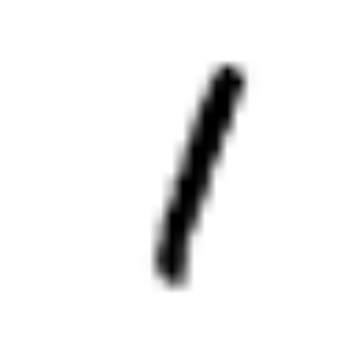

In [211]:
# Plot a random image
sample_number = 5
plt.imshow(img_data[sample_number].reshape(28,28), cmap="gray_r")
plt.axis('off')

img_gt, img_pred = gtlabel[sample_number], pred[sample_number]
print("Image Label: ", img_pred)

## Pooling Layer

Often times, one needs to control the number of parameters especially when having deep networks. For every layer of the convolution layer output (each layer, corresponds to the output of a filter), one can have a pooling layer. Pooling layers are typically introduced to:
- Reduce the shape of the current layer (speeding up the network),
- Make the model more tolerant to changes in object location in the image. For example, even when a digit is shifted to one side of the image instead of being in the middle, the classifer would perform the classification task well.

The calculation on a pooling node is much simpler than a normal feedforward node.  It has no weight, bias, or activation function.  It uses a simple aggregation function (like max or average) to compute its output.  The most commonly used function is "max" - a max pooling node simply outputs the maximum of the input values corresponding to the filter position of the input. The figure below shows the input values in a 4 x 4 region. The max pooling window size is 2 x 2 and starts from the top left corner, and uses a stride of 2x2.  The maximum value within the window becomes the output of the region. Every time the model is shifted by the amount specified by the stride parameter (as shown in the figure below) and the maximum pooling operation is repeated. 
![maxppool](https://cntk.ai/jup/201/MaxPooling.png)

Another alternative is average pooling, which emits that average value instead of the maximum value. The two different pooling opearations are summarized in the animation below.

In [212]:
# Plot images with strides of 2 and 1 with padding turned on
images = [("https://www.cntk.ai/jup/c103d_max_pooling.gif" , 'Max pooling'),
          ("https://www.cntk.ai/jup/c103d_average_pooling.gif", 'Average pooling')]

for im in images:
    print(im[1])
    display(Image(url=im[0], width=200, height=200))

Max pooling


Average pooling


# Typical convolution network

![mnist-conv-mp](http://www.cntk.ai/jup/conv103d_mnist-conv-mp.png)

A typical CNN contains a set of alternating convolution and pooling layers followed by a dense output layer for classification. You will find variants of this structure in many classical deep networks (VGG, AlexNet etc).  This is in contrast to the MLP network we used in Lab 3, which consisted of 2 dense layers followed by a dense output layer.  

The illustrations are presented in the context of 2-dimensional (2D) images, but the concept and the CNTK components can operate on any dimensional data. The above schematic shows 2 convolution layer and 2 pooling layers. A typical strategy is to increase the number of filters in the deeper layers while reducing the spatial size of each intermediate layers. 

## Task: Create a network with Average Pooling

Typical convolutional networks have interlacing convolution and pooling layers. The previous model had only convolution layer. In this section, you will create a model with the following architecture.

![conv-only](https://www.cntk.ai/jup/cntk103d_conv_max2.png)

You will use the CNTK [Average Pooling](https://cntk.ai/pythondocs/cntk.layers.layers.html#cntk.layers.layers.AveragePooling) function to achieve this task. You will edit the `create_model` function below and add the Average Pooling operation. 



In [29]:
# Modify this model
def create_model(features):
    with C.layers.default_options(init = C.glorot_uniform(), activation = C.relu):
            h = features
            
            h = C.layers.Convolution2D(filter_shape=(5,5), 
                                       num_filters=8, 
                                       strides=(2,2), 
                                       pad=True, name='first_conv')(h)
            h = C.layers.Convolution2D(filter_shape=(5,5), 
                                       num_filters=16, 
                                       strides=(2,2), 
                                       pad=True, name='second_conv')(h)
            r = C.layers.Dense(num_output_classes, activation = None, name='classify')(h)
            return r
        
# do_train_test()

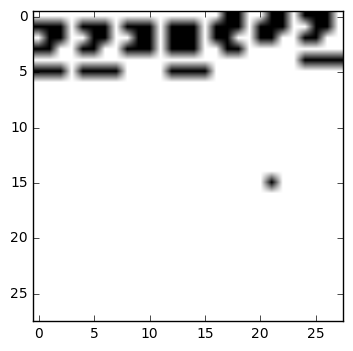

In [213]:
import PIL

imgfile = "MysteryNumberD (2).bmp" 
im = PIL.Image.open(imgfile) 

p = np.array(im)
p = p.astype(np.float32)
plt.imshow(p, cmap="gray_r")

In [214]:
p = np.reshape(p, [1, 28, 28])
p_predict = out.eval(p)

In [215]:
print(p_predict)
print(np.argmax(p_predict))

[[  5.71808480e-02   1.90573230e-01   7.40657628e-01   2.75165098e-06
    3.02581432e-10   4.66640480e-03   1.90860774e-05   6.89990073e-03
    1.39971830e-08   1.36566825e-07]]
2


**Knowledge Check**: How many parameters do we have in this second model (as shown in the figure)? 


**Suggested Explorations**
- Add average pooling layer after each of the two convolution layer. Use the parameters as shown in the figure. 
- Does use of LeakyRelu help improve the error rate?
- What percentage of the parameter does the last dense layer contribute w.r.t. the overall number of parameters for (a) purely two convolutional layer and (b) alternating 2 convolutional and average pooling layers   